# Sharvari Gote
## Introduction to Robotics


# Project 2: inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [2]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project2'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project2/')
    os.chdir('/content/ROB6003/Project2/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [74]:
import numpy as np
import robot_visualizer
import time

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7001/static/


C:\Users\SHARVARI\anaconda3\envs\robotics\lib\site-packages\pinocchio\shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


In [75]:
np.random.seed(45)

# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [76]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.98901151 0.54954473 0.2814473  0.07728957 0.4444695  0.47280797
 0.048522  ]


## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [77]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.)

In [78]:
from scipy.linalg import expm 
# Function that transforms a 3D vector (numpy array) into a skew symmetric matrix
# working checked 
def vec_to_skew(w):
    return np.array([[0, -w.item(2), w.item(1)],
                     [w.item(2), 0, -w.item(0)],
                     [-w.item(1), w.item(0), 0]])

# Write a function twist_to_skew(V) that transforms a 6D twist into a 4x4 matrix (use vec_to_skew)
# working checked
def twist_to_skew(V):
    V = np.array(V)
    b = np.zeros((4,4))
    r = np.array([[V.item(0)],[V.item(1)],[V.item(2)]])
    m = vec_to_skew(r)
    b = np.array([[m.item(0),m.item(1), m.item(2),V.item(3)],
                     [m.item(3),m.item(4),m.item(5),V.item(4)],
                     [m.item(6),m.item(7),m.item(8),V.item(5)],
                    [0,0,0,0]])
    return b

#Write a function exp_twist_bracket(V) that returns the exponential of a (bracketed) twist  e[V]  
#where the input to the function is a 6D twist
# function checked 
def exp_twist_bracket(V):

    V = np.array(V)
    sk_v = twist_to_skew(V)
    exp_t = expm(sk_v)
    return exp_t
    
# To get rotation matrix R from homogrnous transform   
# checked properly
def rorR(w):
    w=np.array(w)
    return np.array([[w.item(0),w.item(1),w.item(2)],
                    [w.item(4),w.item(5),w.item(6)],
                    [w.item(8),w.item(9),w.item(10)]])

# To get position matrix P from homogrnous transform
# checked properly
def posP(w):
    w=np.array(w)
    return np.array([[w.item(3)],
                    [w.item(7)],
                    [w.item(11)]])

#Write a function inverseT(T) that returns the inverse of a homogeneous transform T
# checked properly 
def inverseT(T):
    R=rorR(T)
    p=posP(T)
    R_trans = np.linalg.inv(R)
    R_trans_p = -np.dot(R_trans,p)
    T_inverse = np.array([[R_trans.item(0),R_trans.item(1), R_trans.item(2),R_trans_p.item(0)],
                     [R_trans.item(3),R_trans.item(4),R_trans.item(5),R_trans_p.item(1)],
                     [R_trans.item(6),R_trans.item(7),R_trans.item(8),R_trans_p.item(2)],
                    [0,0,0,1]])
    return T_inverse

# Gives adjoint transformation
def getAdjoint(T):
    T = np.array(T)
    R=rorR(T)
    p=posP(T)
    pt=vec_to_skew(p)@R
    return np.array([[R.item(0),R.item(1),R.item(2),0,0,0],
                     [R.item(3),R.item(4),R.item(5),0,0,0],
                     [R.item(6),R.item(7),R.item(8),0,0,0],
                     [pt.item(0),pt.item(1),pt.item(2),R.item(0),R.item(1),R.item(2)],
                     [pt.item(3),pt.item(4),pt.item(5),R.item(3),R.item(4),R.item(5)],
                     [pt.item(6),pt.item(7),pt.item(8),R.item(6),R.item(7),R.item(8)]])


In [79]:
def forward_kinematics(theta):
    theta =np.array(theta)
    # Homogenous transform when all thetas are zero
    M = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1.301],[0,0,0,1]])
    # e([s1]*theta1)
    s1 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk1 = twist_to_skew(s1)
    ex_S_twi_sk1 = expm(S_twi_sk1*theta.item(0))
    # e([s2]*theta2)
    s2 = np.array([[0.],[1.],[0.],[-0.360],[0.
                                           ],[0.]])
    S_twi_sk2 = twist_to_skew(s2)
    ex_S_twi_sk2 = expm(S_twi_sk2*theta.item(1))
    # (e[s3]*theta3)
    s3 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk3 = twist_to_skew(s3)
    ex_S_twi_sk3 = expm(S_twi_sk3*theta.item(2))
    # e([s4]*theta4)
    s4 = np.array([[0.],[-1.],[0.],[0.78],[0.],[0.]])
    S_twi_sk4 = twist_to_skew(s4)
    ex_S_twi_sk4 = expm(S_twi_sk4*theta.item(3))
    # e[s5]*theta5
    s5 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk5 = twist_to_skew(s5)
    ex_S_twi_sk5 = expm(S_twi_sk5*theta.item(4))
    # e[s6]*theta6
    s6 = np.array([[0.],[1.],[0.],[-1.18],[0.],[0.]])
    S_twi_sk6 = twist_to_skew(s6)
    ex_S_twi_sk6 = expm(S_twi_sk6*theta.item(5))
    # e[s7]*theta7
    s7 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk7 = twist_to_skew(s7)
    ex_S_twi_sk7 = expm(S_twi_sk7*theta.item(6))
    t = ex_S_twi_sk1@ex_S_twi_sk2@ex_S_twi_sk3@ex_S_twi_sk4@ex_S_twi_sk5@ex_S_twi_sk6@ex_S_twi_sk7@M

    return t

In [80]:
def get_space_jacobian(theta):
    theta =np.array(theta)
    #e[s1]*theta1
    s1 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk1 = twist_to_skew(s1)
    ex_S_twi_sk1 = expm(S_twi_sk1*theta.item(0))
    # space jocabian for 1st joint
    
    Js_1 = s1
    # e[s2]*theta2
    s2 = np.array([[0.],[1.],[0.],[-0.360],[0.],[0.]])
    S_twi_sk2 = twist_to_skew(s2)
    ex_S_twi_sk2 = expm(S_twi_sk2*theta.item(1))
    
    # space jocabian for 2nd joint
    Js_2 = getAdjoint(ex_S_twi_sk1)@s2
    
    # e[s3]*theta3
    s3 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk3 = twist_to_skew(s3)
    ex_S_twi_sk3 = expm(S_twi_sk3*theta.item(2))
    
    e_12 = ex_S_twi_sk1@ex_S_twi_sk2
    
    #  space jocabian for 3rd joint
    Js_3 = getAdjoint(e_12)@s3
    
    # e[s4]*theta4
    s4 = np.array([[0.],[-1.],[0.],[0.78],[0.],[0.]])
    S_twi_sk4 = twist_to_skew(s4)
    ex_S_twi_sk4 = expm(S_twi_sk4*theta.item(3))
    
    e_23 = e_12@ex_S_twi_sk3
    
    #  space jocabian for 4th joint
    Js_4 = getAdjoint(e_23)@s4
    
    # e[s5]*theta5
    s5 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk5 = twist_to_skew(s5)
    ex_S_twi_sk5 = expm(S_twi_sk5*theta.item(4))
    
    e_34 = e_23@ex_S_twi_sk4
    #  space jocabian for 5th joint
    Js_5 = getAdjoint(e_34)@s5
    
    # e[s6]*theta6
    s6 = np.array([[0.],[1.],[0.],[-1.18],[0.],[0.]])
    S_twi_sk6 = twist_to_skew(s6)
    ex_S_twi_sk6 = expm(S_twi_sk6*theta.item(5))
    
    e_45 = e_34@ex_S_twi_sk5
    
    #  space jocabian for 6th joint
    Js_6 = getAdjoint(e_45)@s6
    
    s7 = np.array([[0.],[0.],[1.],[0.],[0.],[0.]])
    S_twi_sk7 = twist_to_skew(s7)
    ex_S_twi_sk7 = expm(S_twi_sk7*theta.item(6))
    
    e_56 = e_45@ex_S_twi_sk6
    
    # space jocabian for 7th joint
    Js_7 = getAdjoint(e_56)@s7
    
    J = np.hstack([Js_1,Js_2,Js_3,Js_4,Js_5,Js_6,Js_7])
    return J    

# INVERSE KINEMATICS



In [81]:
##Write a function compute_IK_position that gets a desired end-effector 3D position (in spatial frame) and 
#returns a vector of joint angles that solves the inverse kinematics problem
def compute_IK_position(desired_end_effector_pos):
    #theta = np.zeros([1, 7])
    theta = q 
    alpha = 0.1
    for i in range(700):
        t = forward_kinematics(theta)
        T_bs = inverseT(t)
        Adj_t = getAdjoint(T_bs)
        space_jacobian = get_space_jacobian(theta)
        body_jacobian = Adj_t@space_jacobian
        trans = t[:3, 3]
        t[0:3,0:3] = np.eye(3)
        f_theta = np.array(t[:3, 3])
        error = desired_end_effector_pos - f_theta
        jacobian_pos = body_jacobian[3:,:]
        jacobian_pos_inv = np.linalg.pinv(jacobian_pos)
        
        if(np.linalg.norm(error)> 0.001):
            d_theta = jacobian_pos_inv@error
            theta = theta + np.dot(alpha,d_theta)
    print("Error obtained : {}".format(np.linalg.norm(error)))
    return theta


In [82]:
for i in range(desired_endeff.shape[1]):
    trail_1 = compute_IK_position(desired_endeff[:,i])
    trail_1 = np.round(trail_1, 14)
    print('Joint Configuration {}: \n{}\n'.format(i+1, trail_1.reshape((7, 1))))
    robot_visualizer.display_robot(trail_1)

Error obtained : 1.2191950986580518
Joint Configuration 1: 
[[ 1.24636554e+01]
 [ 4.36589239e+01]
 [ 2.89167912e+01]
 [ 2.18225012e+01]
 [-1.56732475e+00]
 [ 8.85613098e+01]
 [ 4.85220009e-02]]

Error obtained : 0.000994381579923104
Joint Configuration 2: 
[[ 4.60381099]
 [-6.76615386]
 [ 2.51374219]
 [-1.27562476]
 [ 0.02377788]
 [ 5.35310915]
 [ 0.048522  ]]

Error obtained : 0.0009884597044628055
Joint Configuration 3: 
[[-0.29881835]
 [-0.11584025]
 [-0.31537707]
 [ 1.96880147]
 [ 0.7066368 ]
 [ 1.63572539]
 [ 0.048522  ]]

Error obtained : 0.0009471876128474652
Joint Configuration 4: 
[[-0.39422152]
 [ 0.5571721 ]
 [ 0.4836117 ]
 [ 1.15912762]
 [ 0.41391938]
 [-0.11381041]
 [ 0.048522  ]]

Error obtained : 0.6495117623635188
Joint Configuration 5: 
[[ 2.79100954e+00]
 [-2.29658650e+02]
 [ 3.55785155e+00]
 [ 2.70602618e+00]
 [-5.76116172e-01]
 [ 3.11331965e+00]
 [ 4.85220009e-02]]

Error obtained : 0.7761799259592167
Joint Configuration 6: 
[[-1.07715452e+01]
 [-6.28728715e+01]
 [-

# Nullspace

In [83]:

def compute_IK_position_nullspace(desired_end_effector_pos):
    #theta = np.zeros([1, 7])
    theta = q
    alpha = 0.01
    theta_initial = np.array([1,1,-1,-1,1,1,1])
    for i in range(700):
        t = forward_kinematics(theta)
        T_bs = inverseT(t)
        Adj_t = getAdjoint(T_bs)
        space_jacobian = get_space_jacobian(theta)
        body_jacobian = Adj_t@space_jacobian
        f_theta = np.array(t[:3, 3])
        error = desired_end_effector_pos - f_theta
        
        jacobian_pos = body_jacobian[3:,:]
        
        jacobian_pos_inv = np.linalg.pinv(jacobian_pos)
        #print(jacobian_inv)
        
        if(np.linalg.norm(error)> 0.001):
            #epsilon =  10e04
            d_theta = jacobian_pos_inv@error +alpha*(np.eye(7) - (jacobian_pos_inv@jacobian_pos))@theta_initial
            #if theta.all() in range(-3.14,3.14):
            theta = theta + d_theta
    print(np.linalg.norm(error))
    return theta


In [84]:
for i in range(desired_endeff.shape[1]):
    trail_2 = compute_IK_position_nullspace(desired_endeff[:,i])
    trail_2 = np.round(trail_2, 14)
    print('Joint Configuration {}: \n{}\n'.format(i+1, trail_2.reshape((7, 1))))
    #robot_visualizer.display_robot(trail_2)

1.1629028617583983
Joint Configuration 1: 
[[ -376.73685425]
 [  199.16052869]
 [  105.7847453 ]
 [ -378.65298599]
 [    8.91019543]
 [-2020.8475001 ]
 [    7.048522  ]]

0.0006499875189943068
Joint Configuration 2: 
[[ 23.62318931]
 [-26.24168629]
 [-29.89720694]
 [ 49.40532328]
 [  5.01195741]
 [-23.90009425]
 [  1.948522  ]]

0.0005969131476723757
Joint Configuration 3: 
[[ -7.30347257]
 [  6.09490694]
 [-12.44032396]
 [-23.20588186]
 [ -6.87335876]
 [-79.77163893]
 [  0.578522  ]]

0.0007613627105990819
Joint Configuration 4: 
[[-83.87147495]
 [ -5.33519575]
 [ 15.7556847 ]
 [ 49.0764983 ]
 [-14.44517438]
 [ 31.77763649]
 [  0.958522  ]]

0.0006366322724824947
Joint Configuration 5: 
[[-10.93945551]
 [ 10.82009152]
 [ -3.68735436]
 [-54.80692935]
 [ 11.3351691 ]
 [113.13389988]
 [  2.478522  ]]

1.8032079920477229
Joint Configuration 6: 
[[-240.60930446]
 [  83.07953223]
 [  14.1139854 ]
 [  -8.03020788]
 [  42.68930334]
 [-527.80879562]
 [   7.048522  ]]

1.3420715499297822
Joint 

## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

Compute inverse kinematics solutions to reach both goals

In [86]:
end_effector_goal1 = np.array([0.7,0.2,0.7])
end_effector_goal2 = np.array([0.3,0.5,0.9])
theta_goal_1 = compute_IK_position(end_effector_goal1)
theta_goal_2 = compute_IK_position(end_effector_goal2)

print(theta_goal_1)
print(theta_goal_2)


Error obtained : 0.0009547106335782152
Error obtained : 0.0009791546679129353
[ 4.48667318e+01  7.62570690e+00 -3.02081742e+01  7.38766371e+00
 -1.79587258e+00  8.13752141e+01  4.85220009e-02]
[ 3.3667847  -7.18425963  1.95529522 -5.29000223  0.04831761  5.81919111
  0.048522  ]


# function get_point_to_point_motion

In [87]:
def get_point_to_point_motion(t, T, des_inti_pos, des_end_pos):
    position = des_inti_pos + (10/T**3 * t**3 -15/T**4 * t**4 + 6/T**5 * t**5) * (des_end_pos - des_inti_pos)
    velocity = (30/T**3 * t**2 -60/T**4 * t**3 + 30/T**5 * t**4) * (des_end_pos - des_inti_pos)
    return position, velocity
    


t = 10
theta_initial = np.array([0,0,0,0,0,0,0])
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

if t<=5 :
    desired_joint_positions,desired_joint_velocities = get_point_to_point_motion(t,T=5, des_inti_pos = theta_initial, des_end_pos = theta_goal_1)
else:
    desired_joint_positions,desired_joint_velocities = get_point_to_point_motion(t-5,T=5, des_inti_pos = theta_goal_1, des_end_pos = theta_goal_2)
print(desired_joint_positions.reshape(1,len(end_effector_goal1)).T)
print(desired_joint_velocities)
    
    

# Modify the robot_controller function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function get_point_to_point_motion you wrote above.

In [88]:
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])


## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
       
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
   
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
   
   
    # when t>5. we generate sines for joint 2 and 3 as an example
    #t = 10
    theta_initial = np.array([0,0,0,0,0,0,0])
    if t<=5 :
        position, velocity = get_point_to_point_motion(t,T=5, des_inti_pos = theta_initial, des_end_pos = theta_goal_1)
                                                       
        desired_joint_positions = np.reshape(position,(1,len(position))).T
        desired_joint_velocities = np.reshape(velocity ,(1,len(velocity))).T
    else:
        position, velocity  = get_point_to_point_motion(t-5,T=5, des_inti_pos = theta_goal_1, des_end_pos = theta_goal_2)
        desired_joint_positions = np.reshape(position, (1,len(position))).T
        desired_joint_velocities = np.reshape(velocity , (1,len(velocity))).T
  
   
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
   
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
   
   
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
   
    return desired_joint_torques
       
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

# Plot the resulting joint simulated and desired positions and velocities

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

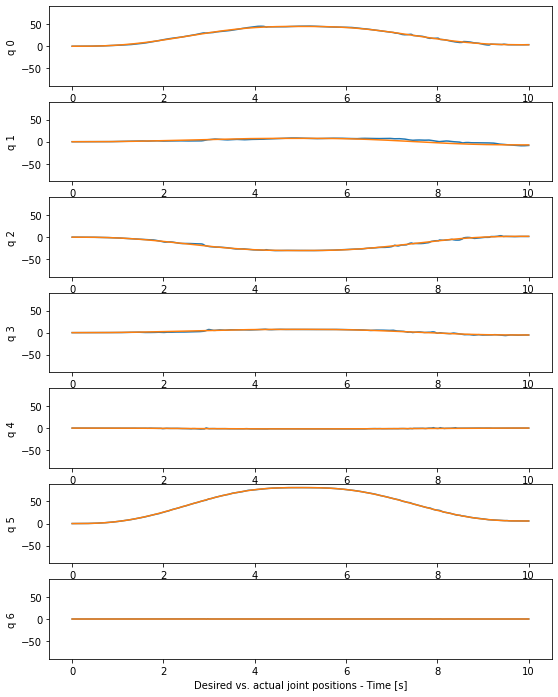

In [89]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-90,90])
    
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

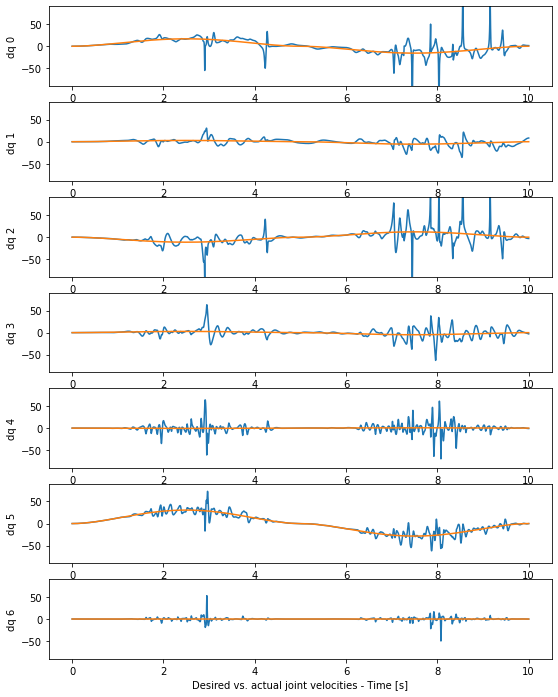

In [90]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-90,90]) 
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

# End effector position 


Text(0, 0.5, 'Z  positions')

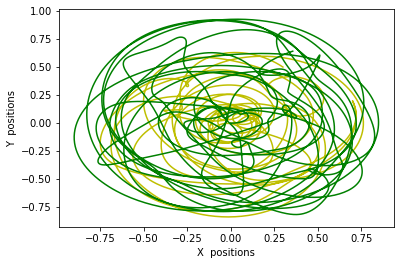

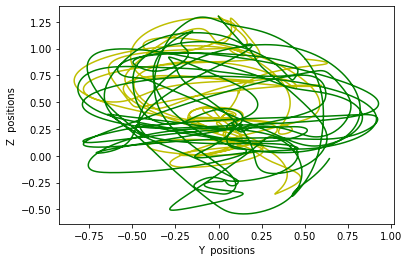

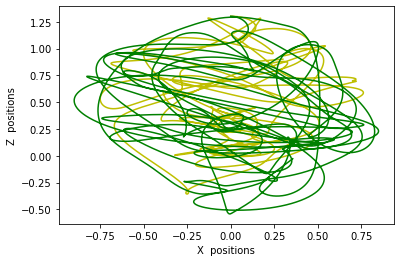

In [92]:
x = []
y = []
z = []
x_init = []
y_init = []
z_init = []
for j in range(0,save_joint_positions.shape[1]):
    thetas = save_des_joint_positions[:,j]
    pos = forward_kinematics(thetas)[:-1: , -1]
    x.append(pos[0])
    y.append(pos[1])
    z.append(pos[2])

    inti_thetas = save_joint_positions[:,j]
    intii_pos = forward_kinematics(inti_thetas)[:-1: , -1]
    x_init.append(intii_pos[0])
    y_init.append(intii_pos[1])
    z_init.append(intii_pos[2])

plt.figure()
plt.plot(x,y,"y")
plt.plot(x_init,y_init,"g")
plt.xlabel("X  positions")
plt.ylabel("Y  positions")

plt.figure()
plt.plot(y,z,"y")
plt.plot(y_init,z_init,"g")
plt.xlabel("Y  positions")
plt.ylabel("Z  positions")


plt.figure()
plt.plot(x,z,"y")
plt.plot(x_init,z_init,"g")
plt.xlabel("X  positions")
plt.ylabel("Z  positions")


# End effector velocity

Text(0, 0.5, 'Z  positions')

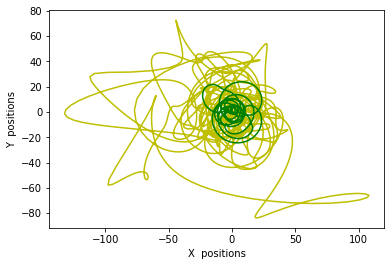

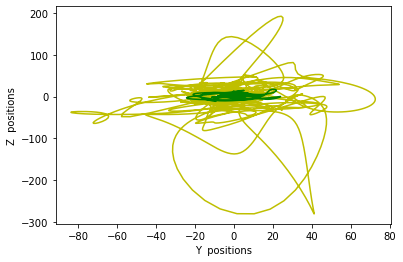

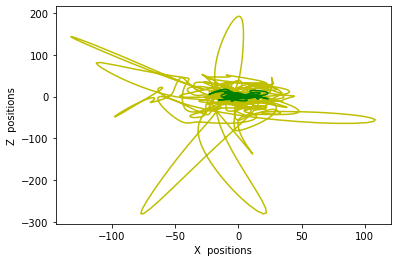

In [94]:
x = []
y = []
z = []
x_des = []
y_des = []
z_des = []
for j in range(0,save_des_joint_velocities.shape[1]):
    
    thetas = save_des_joint_positions[:,j]
    vel = np.array(save_joint_velocities[:,j])
    s_j = get_space_jacobian(thetas)
    s_sc = s_j@vel
    
    
    x.append(s_sc[0])
    y.append(s_sc[1])
    z.append(s_sc[2])

    des_thetas = save_des_joint_positions[:,j]
    des_vel = np.array(save_des_joint_velocities[:,j])
    des_s_j = get_space_jacobian(des_thetas)
    des_sc = des_s_j@des_vel
    x_des.append(des_sc[3])
    y_des.append(des_sc[4])
    z_des.append(des_sc[5])

plt.figure()
plt.plot(x,y,"y")
plt.plot(x_des,y_des,"g")
plt.xlabel("X  positions")
plt.ylabel("Y  positions")

plt.figure()
plt.plot(y,z,"y")
plt.plot(y_des,z_des,"g")
plt.xlabel("Y  positions")
plt.ylabel("Z  positions")


plt.figure()
plt.plot(x,z,"y")
plt.plot(x_des,z_des,"g")
plt.xlabel("X  positions")
plt.ylabel("Z  positions")


## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [68]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    theta_initial = np.array([0,0,0,0,0,0,0])
    if t<=5 :
        position, velocity = get_point_to_point_motion(t,T=5, des_inti_pos = theta_initial, des_end_pos = theta_goal_1)
                                                       
        desired_joint_positions = np.reshape(position,(1,len(position))).T
        desired_joint_velocities = np.reshape(velocity ,(1,len(velocity))).T
    else:
        position, velocity  = get_point_to_point_motion(t=10,T=5, des_inti_pos = theta_goal_1, des_end_pos = theta_goal_2)
        desired_joint_positions = np.reshape(position, (1,len(position))).T
        desired_joint_velocities = np.reshape(velocity , (1,len(velocity))).T
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

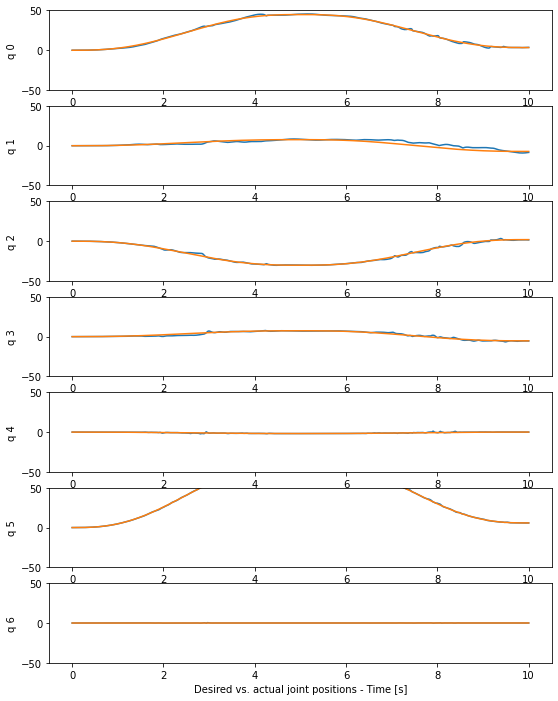

In [97]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-50,50])
    
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

## Question 4: Impedance control and gravity compensation
As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ``robot_visualizer.rnea(q,dq,ddq)`` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q,\dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?

In [10]:
T = 10.

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
    ##TODO - implement gravity compensation and impedance control
    
    desired_joint_torques = -np.diag(D) @ joint_velocities
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)